In [69]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import math as m
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV,KFold
import seaborn as sns

In [70]:
df_un_factor=pd.read_csv('ranking_data_sets/imdb_movie_stars_v3.csv')

In [71]:
len(df_un_factor['genres'].unique())

8

In [72]:
df_un_factor['genres'].unique()

array(['Comedy', 'Action & Adventure', 'Drama', 'Documentary & Biography',
       'Horror & Thriller', 'Family & Animation', 'Other',
       'Crime & Mystery'], dtype=object)

In [73]:
df_un_factor_act=df_un_factor[df_un_factor['genres']== 'Action & Adventure']

In [74]:
df_sort=df_un_factor_act.sort_values(by='averageRating',ascending= False)

In [75]:
df_sort[['primaryName','primaryTitle','averageRating',"numVotes", "runtimeMinutes",'genres','startYear']]

,primaryName,primaryTitle,averageRating,numVotes,runtimeMinutes,genres,startYear
400,Chris Hemsworth,Avengers: Infinity War,8.4,1171914,149,Action & Adventure,2018
401,Chris Hemsworth,Avengers: Endgame,8.4,1232403,181,Action & Adventure,2019
5,Jennifer Aniston,The Iron Giant,8.1,220024,86,Action & Adventure,1999
61,Johnny Depp,Pirates of the Caribbean: The Curse of the Bla...,8.1,1186432,143,Action & Adventure,2003
393,Chris Hemsworth,Rush,8.1,504420,123,Action & Adventure,2013
...,...,...,...,...,...,...,...
364,Om Puri,Policegiri,4.2,1574,141,Action & Adventure,2013
252,Rinko Kikuchi,Assault Girls,3.8,1325,65,Action & Adventure,2009
372,Om Puri,Warrior Savitri,3.1,878,136,Action & Adventure,2016
160,Ben Kingsley,BloodRayne,3.0,36907,95,Action & Adventure,2005


In [76]:
def clean_data(df):

    def runtime_category(runtime):
        if runtime <= 120: return 0
        elif runtime <= 150: return 1
        else: return 2
    df['runtimeMinutes'] = df['runtimeMinutes'].apply(runtime_category)

    def votes_category(votes):
        if votes <= 10000: return 0
        elif votes <= 50000: return 1
        elif votes <= 100000: return 2
        else: return 3
    df['numVotes'] = df['numVotes'].astype(int).apply(votes_category)
    
    def startYear_category(year):
        if year <= 2000: return 0
        elif year <= 2010: return 1
        elif year <= 2020: return 2
        else: return 3
    df['startYear'] = df['startYear'].astype(int).apply(startYear_category)

    name_map = {'Scarlett Johansson': 0,
            'Emma Mackey': 1,
            'Margot Robbie': 2,
            'Johnny Depp': 3,
            'Jason Momoa': 4,
            'Rinko Kikuchi': 5,
            'Ben Kingsley': 6,
            'Om Puri': 7,
            'Jennifer Aniston':8,
            'Angelina Jolie': 9,
            'Taylor Kitsch':10,
            'Chris Hemsworth':11,}
    
    df['primaryName'] = df['primaryName'].apply(lambda x: name_map.get(x, -1))
    
    genre_map = {'Comedy': 0, 
                 'Action & Adventure': 1, 
                 'Drama': 2, 
                 'Documentary & Biography': 3,
                 'Horror & Thriller': 4, 
                 'Family & Animation': 5, 
                 'Other': 6, 
                 'Crime & Mystery': 7}
    
    df['genres'] = df['genres'].apply(lambda x: genre_map.get(x, -1)) 

    return df

In [77]:
df_clean = clean_data(df_un_factor.copy())

In [78]:
df_action_clean=clean_data(df_un_factor_act.copy())

In [79]:
df_action_clean

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,films_tv_participated,tconst_x,averageRating,numVotes,tconst_y,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
5,nm0000098,8,1969,\N,"actress,producer,soundtrack","tt0279113,tt0108778,tt3442006,tt1723121",tt0129167,tt0129167,8.1,3,tt0129167,movie,The Iron Giant,The Iron Giant,0,0,\N,0,1
20,nm0000098,8,1969,\N,"actress,producer,soundtrack","tt0279113,tt0108778,tt3442006,tt1723121",tt1038919,tt1038919,5.5,3,tt1038919,movie,The Bounty Hunter,The Bounty Hunter,0,1,\N,0,1
23,nm0000098,8,1969,\N,"actress,producer,soundtrack","tt0279113,tt0108778,tt3442006,tt1723121",tt15255288,tt15255288,5.7,2,tt15255288,movie,Murder Mystery 2,Murder Mystery 2,0,3,\N,0,1
25,nm0000098,8,1969,\N,"actress,producer,soundtrack","tt0279113,tt0108778,tt3442006,tt1723121",tt1618434,tt1618434,6.0,3,tt1618434,movie,Murder Mystery,Murder Mystery,0,2,\N,0,1
33,nm0000098,8,1969,\N,"actress,producer,soundtrack","tt0279113,tt0108778,tt3442006,tt1723121",tt4624424,tt4624424,6.8,2,tt4624424,movie,Storks,Storks,0,2,\N,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,nm3053338,2,1990,\N,"actress,producer,soundtrack","tt7713068,tt0993846,tt1386697,tt5580036",tt1489264,tt1489264,2.6,0,tt1489264,movie,Vigilante,Vigilante,0,1,\N,0,1
420,nm3053338,2,1990,\N,"actress,producer,soundtrack","tt7713068,tt0993846,tt1386697,tt5580036",tt1517268,tt1517268,7.0,3,tt1517268,movie,Barbie,Barbie,0,3,\N,0,1
426,nm3053338,2,1990,\N,"actress,producer,soundtrack","tt7713068,tt0993846,tt1386697,tt5580036",tt4463816,tt4463816,5.3,1,tt4463816,movie,Terminal,Terminal,0,2,\N,0,1
429,nm3053338,2,1990,\N,"actress,producer,soundtrack","tt7713068,tt0993846,tt1386697,tt5580036",tt6334354,tt6334354,7.2,3,tt6334354,movie,The Suicide Squad,The Suicide Squad,0,3,\N,1,1


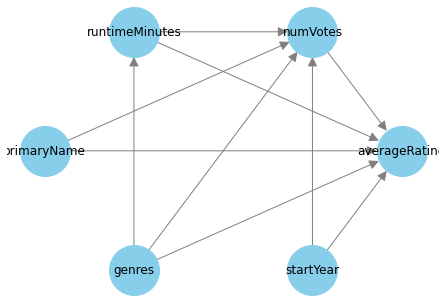

In [80]:
G = nx.DiGraph()

nodes = ["averageRating", "numVotes", "runtimeMinutes", "primaryName", "genres"]
G.add_nodes_from(nodes)


# edges = [
#     ("primaryName", "averageRating"), 
#     ("primaryName", "numVotes"),
#     ("numVotes", "averageRating"),
#     ("runtimeMinutes", "averageRating"),
#     ("genres", "averageRating"),
#     ("startYear", "averageRating"),
#     ("startYear", "numVotes")
# ]

edges = [
    ("primaryName", "averageRating"), 
    ("primaryName", "numVotes"),
    ("numVotes", "averageRating"),
    ("runtimeMinutes", "numVotes"),
    ("runtimeMinutes", "averageRating"),
    ("genres", "numVotes"),
    ("genres", "runtimeMinutes"),
    ("genres", "averageRating"),
    ("startYear", "averageRating"),
    ("startYear", "numVotes")
]
G.add_edges_from(edges)


layout = nx.circular_layout(G)

nx.draw(G, with_labels=True, node_color='skyblue', node_size=2500, edge_color='gray', arrowsize=20, pos=layout)

In [81]:
import ranking_funcs

In [82]:
new_G_combined_rf=ranking_funcs.get_new_G_combined_rf(G,df_clean)

In [83]:
new_rank=ranking_funcs.get_ranking_query(new_G_combined_rf, df_clean, len(df_clean), {'primaryName':8}, 'averageRating', {'primaryName':9}, opt="fix")

In [84]:
new_rank_action=new_rank[new_rank['genres'] == 1]

In [85]:
new_rank_action[['primaryName','primaryTitle','averageRating',"numVotes", "runtimeMinutes",'genres','startYear']]

,primaryName,primaryTitle,averageRating,numVotes,runtimeMinutes,genres,startYear
401,11,Avengers: Endgame,8.4,3.0,2,1,2
400,11,Avengers: Infinity War,8.4,3.0,1,1,2
5,8,The Iron Giant,8.1,3.0,0,1,0
393,11,Rush,8.1,3.0,1,1,2
61,3,Pirates of the Caribbean: The Curse of the Bla...,8.1,3.0,1,1,1
...,...,...,...,...,...,...,...
157,6,A Sound of Thunder,4.2,1.0,0,1,1
252,5,Assault Girls,3.8,0.0,0,1,1
372,7,Warrior Savitri,3.1,0.0,1,1,2
160,6,BloodRayne,3.0,1.0,0,1,1


In [86]:
df_un_factor[df_un_factor['primaryTitle']=='John Carter']

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,films_tv_participated,tconst_x,averageRating,numVotes,tconst_y,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
404,nm2018237,Taylor Kitsch,1981,\N,"actor,producer,director","tt0758745,tt1440129,tt0401729,tt0458525",tt0401729,tt0401729,6.6,283151,tt0401729,movie,John Carter,John Carter,0,2012,\N,132,Action & Adventure


In [87]:
df_un_factor

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,films_tv_participated,tconst_x,averageRating,numVotes,tconst_y,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,nm0000098,Jennifer Aniston,1969,\N,"actress,producer,soundtrack","tt0279113,tt0108778,tt3442006,tt1723121",tt0107387,tt0107387,4.8,29649,tt0107387,movie,Leprechaun,Leprechaun,0,1992,\N,92,Comedy
1,nm0000098,Jennifer Aniston,1969,\N,"actress,producer,soundtrack","tt0279113,tt0108778,tt3442006,tt1723121",tt0116141,tt0116141,6.0,2912,tt0116141,movie,Dream for an Insomniac,Dream for an Insomniac,0,1996,\N,90,Comedy
2,nm0000098,Jennifer Aniston,1969,\N,"actress,producer,soundtrack","tt0279113,tt0108778,tt3442006,tt1723121",tt0117628,tt0117628,6.0,18345,tt0117628,movie,She's the One,She's the One,0,1996,\N,96,Comedy
3,nm0000098,Jennifer Aniston,1969,\N,"actress,producer,soundtrack","tt0279113,tt0108778,tt3442006,tt1723121",tt0119896,tt0119896,5.5,21220,tt0119896,movie,Picture Perfect,Picture Perfect,0,1997,\N,101,Comedy
4,nm0000098,Jennifer Aniston,1969,\N,"actress,producer,soundtrack","tt0279113,tt0108778,tt3442006,tt1723121",tt0120772,tt0120772,6.0,21250,tt0120772,movie,The Object of My Affection,The Object of My Affection,0,1998,\N,111,Comedy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,nm3053338,Margot Robbie,1990,\N,"actress,producer,soundtrack","tt7713068,tt0993846,tt1386697,tt5580036",tt7131622,tt7131622,7.6,814002,tt7131622,movie,Once Upon a Time in Hollywood,Once Upon a Time in... Hollywood,0,2019,\N,161,Comedy
432,nm3053338,Margot Robbie,1990,\N,"actress,producer,soundtrack","tt7713068,tt0993846,tt1386697,tt5580036",tt7713068,tt7713068,6.1,259314,tt7713068,movie,Birds of Prey,Birds of Prey and the Fantabulous Emancipation...,0,2020,\N,109,Action & Adventure
433,nm8076281,Emma Mackey,1996,\N,actress,"tt10366514,tt7657566,tt1517268,tt12374656",tt10366514,tt10366514,6.2,6993,tt10366514,movie,Eiffel,Eiffel,0,2021,\N,108,Drama
434,nm8076281,Emma Mackey,1996,\N,actress,"tt10366514,tt7657566,tt1517268,tt12374656",tt12374656,tt12374656,6.8,7390,tt12374656,movie,Emily,Emily,0,2022,\N,130,Drama


In [88]:
df_2012 = df_un_factor[df_un_factor['startYear']==2012]

In [89]:
df_2012_sort=df_2012.sort_values(by='averageRating',ascending= False)

In [90]:
new_rank=ranking_funcs.get_ranking_query(new_G_combined_rf, df_clean, len(df_clean), {'primaryName':11}, 'averageRating', {'primaryTitle':'John Carter'}, opt="fix")

In [91]:
index_2012=df_2012.index

In [92]:
df_2012_upt=new_rank.loc[index_2012].sort_values(by='averageRating',ascending= False)

In [93]:
df_2012_sort[['primaryName','primaryTitle','averageRating',"numVotes", "runtimeMinutes",'genres','startYear']].head(10)

,primaryName,primaryTitle,averageRating,numVotes,runtimeMinutes,genres,startYear
220,Scarlett Johansson,The Avengers,8.0,1442499,143,Action & Adventure,2012
221,Scarlett Johansson,Hitchcock,6.8,78580,98,Drama,2012
182,Ben Kingsley,It Is No Dream,6.6,63,97,Documentary & Biography,2012
404,Taylor Kitsch,John Carter,6.6,283151,132,Action & Adventure,2012
179,Ben Kingsley,The Dictator,6.4,328537,83,Comedy,2012
408,Taylor Kitsch,Savages,6.4,133533,131,Action & Adventure,2012
71,Johnny Depp,Dark Shadows,6.2,277425,113,Comedy,2012
392,Chris Hemsworth,Snow White and the Huntsman,6.1,299416,127,Action & Adventure,2012
359,Om Puri,Tere Naal Love Ho Gaya,5.9,4562,130,Comedy,2012
266,Jason Momoa,Bullet to the Head,5.7,51922,92,Action & Adventure,2012


In [94]:
df_2012_upt[['primaryName','primaryTitle','averageRating',"numVotes", "runtimeMinutes",'genres','startYear']].head(10)

,primaryName,primaryTitle,averageRating,numVotes,runtimeMinutes,genres,startYear
220,0,The Avengers,8.000000,3.000000,1,1,2
404,11,John Carter,7.005645,3.615168,1,1,2
221,0,Hitchcock,6.800000,2.000000,0,2,2
182,6,It Is No Dream,6.600000,0.000000,0,3,2
179,6,The Dictator,6.400000,3.000000,0,0,2
408,10,Savages,6.400000,3.000000,1,1,2
71,3,Dark Shadows,6.200000,3.000000,0,0,2
392,11,Snow White and the Huntsman,6.100000,3.000000,1,1,2
359,7,Tere Naal Love Ho Gaya,5.900000,0.000000,1,0,2
266,4,Bullet to the Head,5.700000,2.000000,0,1,2


In [95]:
action_jolie_inde=df_action_clean[df_action_clean['primaryName'] == 9].index

In [96]:
df_un_factor.loc[action_jolie_inde].sort_values(by='averageRating',ascending= False)[['primaryName','primaryTitle','averageRating',"numVotes", "runtimeMinutes",'genres','startYear']].head(10)

,primaryName,primaryTitle,averageRating,numVotes,runtimeMinutes,genres,startYear
114,Angelina Jolie,Kung Fu Panda,7.6,504748,92,Action & Adventure,2008
120,Angelina Jolie,Kung Fu Panda 2,7.2,309013,90,Action & Adventure,2011
122,Angelina Jolie,Kung Fu Panda 3,7.1,178376,95,Action & Adventure,2016
121,Angelina Jolie,Maleficent,6.9,394972,97,Action & Adventure,2014
116,Angelina Jolie,Wanted,6.7,404204,110,Action & Adventure,2008
125,Angelina Jolie,Maleficent: Mistress of Evil,6.6,116025,119,Action & Adventure,2019
103,Angelina Jolie,Gone in 60 Seconds,6.5,290787,118,Action & Adventure,2000
112,Angelina Jolie,Mr. & Mrs. Smith,6.5,527822,120,Action & Adventure,2005
106,Angelina Jolie,Beyond Borders,6.4,28922,127,Action & Adventure,2003
119,Angelina Jolie,Salt,6.4,326699,100,Action & Adventure,2010


In [97]:
q2_inde=df_un_factor.loc[action_jolie_inde].sort_values(by='averageRating',ascending= False)[['primaryName','primaryTitle','averageRating',"numVotes", "runtimeMinutes",'genres','startYear']].head(10).index

In [98]:
new_rank=ranking_funcs.get_ranking_query(new_G_combined_rf, df_clean, len(df_clean), {'primaryName':8}, 'averageRating', {'primaryName':9}, opt="fix")

In [99]:
new_rank.loc[q2_inde]

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,films_tv_participated,tconst_x,averageRating,numVotes,tconst_y,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
114,nm0001401,8,1975,\N,"actress,producer,director","tt0944835,tt1587310,tt0824747,tt0172493",tt0441773,tt0441773,7.194355,2.384832,tt0441773,movie,Kung Fu Panda,Kung Fu Panda,0,1,\N,0,1
120,nm0001401,8,1975,\N,"actress,producer,director","tt0944835,tt1587310,tt0824747,tt0172493",tt1302011,tt1302011,6.794355,2.384832,tt1302011,movie,Kung Fu Panda 2,Kung Fu Panda 2,0,2,\N,0,1
122,nm0001401,8,1975,\N,"actress,producer,director","tt0944835,tt1587310,tt0824747,tt0172493",tt2267968,tt2267968,6.694355,2.384832,tt2267968,movie,Kung Fu Panda 3,Kung Fu Panda 3,0,2,\N,0,1
121,nm0001401,8,1975,\N,"actress,producer,director","tt0944835,tt1587310,tt0824747,tt0172493",tt1587310,tt1587310,6.494355,2.384832,tt1587310,movie,Maleficent,Maleficent,0,2,\N,0,1
116,nm0001401,8,1975,\N,"actress,producer,director","tt0944835,tt1587310,tt0824747,tt0172493",tt0493464,tt0493464,6.294355,2.384832,tt0493464,movie,Wanted,Wanted,0,1,\N,0,1
125,nm0001401,8,1975,\N,"actress,producer,director","tt0944835,tt1587310,tt0824747,tt0172493",tt4777008,tt4777008,6.194355,2.384832,tt4777008,movie,Maleficent: Mistress of Evil,Maleficent: Mistress of Evil,0,2,\N,0,1
103,nm0001401,8,1975,\N,"actress,producer,director","tt0944835,tt1587310,tt0824747,tt0172493",tt0187078,tt0187078,6.094355,2.384832,tt0187078,movie,Gone in 60 Seconds,Gone in Sixty Seconds,0,0,\N,0,1
112,nm0001401,8,1975,\N,"actress,producer,director","tt0944835,tt1587310,tt0824747,tt0172493",tt0356910,tt0356910,6.094355,2.384832,tt0356910,movie,Mr. & Mrs. Smith,Mr. & Mrs. Smith,0,1,\N,0,1
106,nm0001401,8,1975,\N,"actress,producer,director","tt0944835,tt1587310,tt0824747,tt0172493",tt0294357,tt0294357,5.994355,0.384832,tt0294357,movie,Beyond Borders,Beyond Borders,0,1,\N,1,1
119,nm0001401,8,1975,\N,"actress,producer,director","tt0944835,tt1587310,tt0824747,tt0172493",tt0944835,tt0944835,5.994355,2.384832,tt0944835,movie,Salt,Salt,0,1,\N,0,1


In [100]:
df_un_factor[df_un_factor['primaryTitle']=='Gandhi']

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,films_tv_participated,tconst_x,averageRating,numVotes,tconst_y,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
127,nm0001426,Ben Kingsley,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0083987,tt0083987,8.0,238386,tt0083987,movie,Gandhi,Gandhi,0,1982,\N,191,Drama


In [101]:
df_clean[df_clean['primaryTitle']=='Gandhi']

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,films_tv_participated,tconst_x,averageRating,numVotes,tconst_y,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
127,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0083987,tt0083987,8.0,3,tt0083987,movie,Gandhi,Gandhi,0,0,\N,2,2


In [102]:
df_clean.sort_values(by='averageRating',ascending= False)

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,films_tv_participated,tconst_x,averageRating,numVotes,tconst_y,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
140,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0108052,tt0108052,9.0,3,tt0108052,movie,Schindler's List,Schindler's List,0,0,\N,2,2
320,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt0308513,tt0308513,8.7,0,tt0308513,movie,Long Da Lishkara,Long Da Lishkara,0,0,\N,1,2
216,nm0424060,0,1984,\N,"actress,soundtrack,producer","tt0335266,tt1798709,tt1441395,tt0848228",tt0482571,tt0482571,8.5,3,tt0482571,movie,The Prestige,The Prestige,0,1,\N,1,2
379,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt6246170,tt6246170,8.5,0,tt6246170,movie,Chaar Sahibzaade 2: Rise of Banda Singh Bahadur,Chaar Sahibzaade 2: Rise of Banda Singh Bahadur,0,2,\N,1,5
400,nm1165110,11,1983,\N,"actor,producer,soundtrack","tt0796366,tt1735898,tt3501632,tt0848228",tt4154756,tt4154756,8.4,3,tt4154756,movie,Avengers: Infinity War,Avengers: Infinity War,0,2,\N,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0383222,tt0383222,3.0,1,tt0383222,movie,BloodRayne,BloodRayne,0,1,\N,0,1
168,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0955411,tt0955411,2.9,0,tt0955411,movie,The Ten Commandments,The Ten Commandments,0,1,\N,0,3
419,nm3053338,2,1990,\N,"actress,producer,soundtrack","tt7713068,tt0993846,tt1386697,tt5580036",tt1489264,tt1489264,2.6,0,tt1489264,movie,Vigilante,Vigilante,0,1,\N,0,1
382,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt8176312,tt8176312,2.6,0,tt8176312,movie,Gul Makai,Gul Makai,0,2,\N,1,2
